In [17]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os

In [18]:
OUTPUT_DIR = "analyzed/"
# Create the directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [19]:
def parse_vcf(vcf_file):
    # Check if the file is gzipped based on its extension
    if vcf_file.endswith('.gz'):
        open_func = gzip.open
    else:
        open_func = open
        
    with open_func(vcf_file, 'rb') as file:
        lines = [line.decode('utf-8').strip() for line in file if not line.startswith(b'##')]
    return pd.DataFrame([line.split('\t') for line in lines[1:]], columns=lines[0].split('\t'))

# Load the VCF file
vcf_df = parse_vcf("/Users/xuanchou/Documents/TWB_1492/microarray/shapeit2.impute2/wgs_left.val.vcf.gz")
vcf_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NGS20140610A,...,NGS1_20170508D,NGS1_20170508B,NGS1_20170505E,NGS1_20170508E,NGS1_20170504E,NGS1_20170506D,NGS1_20170507B,NGS1_20170508G,NGS1_20170601D,NGS1_20170509C
0,chrM,35,.,G,A,.,PASS,variant_collapsed=G35A;rsid;base_qual_hist=0|0...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0/0:1853:0:.:.:PASS:.,...,0/0:2333:0:.:.:PASS:.,0/0:3593:0:.:.:PASS:.,0/0:3214:0:.:.:PASS:.,0/0:2601:0:.:.:PASS:.,0/0:2398:0:.:.:PASS:.,0/0:2191:0:.:.:PASS:.,0/0:2691:0:.:.:PASS:.,0/0:2706:0:.:.:PASS:.,0/0:1894:0:.:.:PASS:.,0/0:5299:0:.:.:PASS:.
1,chrM,41,.,C,CT,.,PASS,variant_collapsed=C41CT;rsid;base_qual_hist=0|...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0/0:1852:0:.:.:PASS:.,...,0/0:2359:0:.:.:PASS:.,0/0:3659:0:.:.:PASS:.,0/0:3232:0:.:.:PASS:.,0/0:2613:0:.:.:PASS:.,0/0:2440:0:.:.:PASS:.,0/0:2230:0:.:.:PASS:.,0/0:2739:0:.:.:PASS:.,0/0:2735:0:.:.:PASS:.,0/0:1917:0:.:.:PASS:.,0/0:5383:0:.:.:PASS:.
2,chrM,41,rs879100564,C,T,.,PASS,variant_collapsed=C41T;hap_defining_variant;rs...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0/0:1852:0:.:.:PASS:.,...,0/0:2359:0:.:.:PASS:.,0/0:3659:0:.:.:PASS:.,0/0:3232:0:.:.:PASS:.,0/0:2613:0:.:.:PASS:.,0/0:2440:0:.:.:PASS:.,0/0:2230:0:.:.:PASS:.,0/0:2739:0:.:.:PASS:.,0/0:2735:0:.:.:PASS:.,0/0:1917:0:.:.:PASS:.,0/0:5383:0:.:.:PASS:.
3,chrM,42,rs377245343,T,TC,.,PASS,variant_collapsed=T42TC;hap_defining_variant;r...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0/0:1832:0:.:.:PASS:.,...,0/0:2331:0:.:.:PASS:.,0/0:3627:0:.:.:PASS:.,0/0:3206:0:.:.:PASS:.,0/0:2575:0:.:.:PASS:.,0/0:2411:0:.:.:PASS:.,0/0:2185:0:.:.:PASS:.,0/0:2691:0:.:.:PASS:.,0/0:2693:0:.:.:PASS:.,0/0:1900:0:.:.:PASS:.,0/0:5265:0:.:.:PASS:.
4,chrM,46,rs1603218267,T,C,.,PASS,variant_collapsed=T46C;rsid=rs1603218267;base_...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0/0:1864:0:.:.:PASS:.,...,0/0:2288:0:.:.:PASS:.,0/0:3545:0:.:.:PASS:.,0/0:3103:0:.:.:PASS:.,0/0:2579:0:.:.:PASS:.,0/0:2372:0:.:.:PASS:.,0/0:2140:0:.:.:PASS:.,0/0:2620:0:.:.:PASS:.,0/0:2651:0:.:.:PASS:.,0/0:1884:0:.:.:PASS:.,0/0:5108:0:.:.:PASS:.


In [20]:
def parse_gt(df):
    # Get GT index
    gt_idx = df.iloc[1]['FORMAT'].split(':').index('GT')
    # Get sample columns (all after 'FORMAT')
    sample_cols = df.columns[df.columns.get_loc('FORMAT')+1:]

    # Initialize an empty list to store results
    results = []

    # Process each sample column
    for col in sample_cols:
        # Check each cell in the column
        for idx, cell in df[col].items():
            if pd.notnull(cell):
                gt = cell.split(':')[gt_idx]
                # Keep only GT part
                df.at[idx, col] = gt
                if gt in ['0|1', '1|0']:
                    # Store the sample, variant, and gt
                    results.append({'Sample': col, 'Variant': df.iloc[idx]['#CHROM'] + ':' + str(df.iloc[idx]['POS']), 'GT': gt})
                    # Convert the genotype to '.|.'
                    df.at[idx, col] = '.|.'

    return df, results

def gt_to_dosage(df):
    # Identify columns containing genotype information
    gt_columns = df.columns[df.columns.get_loc('FORMAT')+1:]

    # Define a function to convert GT to dosage
    def to_dosage(gt):
        # Convert GT to dosage
        if gt in ['0/0', '0|0']:
            return 0
        elif gt in ['1/1', '1|1']:
            return 2
        else:
            return float('nan') # 0/1 or 1/0 should be Nan

    # Apply the conversion for each sample column
    for col in gt_columns:
        df[col] = df[col].apply(to_dosage)

    return df

vcf_df = parse_gt(vcf_df)[0]
vcf_dosage_df = gt_to_dosage(vcf_df)
vcf_dosage_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NGS20140610A,...,NGS1_20170508D,NGS1_20170508B,NGS1_20170505E,NGS1_20170508E,NGS1_20170504E,NGS1_20170506D,NGS1_20170507B,NGS1_20170508G,NGS1_20170601D,NGS1_20170509C
0,chrM,35,.,G,A,.,PASS,variant_collapsed=G35A;rsid;base_qual_hist=0|0...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0.0,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
1,chrM,41,.,C,CT,.,PASS,variant_collapsed=C41CT;rsid;base_qual_hist=0|...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0.0,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
2,chrM,41,rs879100564,C,T,.,PASS,variant_collapsed=C41T;hap_defining_variant;rs...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0.0,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
3,chrM,42,rs377245343,T,TC,.,PASS,variant_collapsed=T42TC;hap_defining_variant;r...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0.0,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
4,chrM,46,rs1603218267,T,C,.,PASS,variant_collapsed=T46C;rsid=rs1603218267;base_...,GT:DP:HL:MQ:TLOD:FT:indel_occurences,0.0,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0


In [21]:
# Create sample ID converting dictionary
import csv

file_path = '/Users/xuanchou/Documents/TWB_1492/survey/lab_info.csv'

with open(file_path, 'r', encoding='utf-8-sig') as file:
    reader = csv.DictReader(file)

    # Constructing the dictionary with conditions to check for valid values
    sample_dict = {}
    for row in reader:
        sample_name = row['Sample_Name']
        twb2_id = row['TWB2_ID']
        platform = row['Platform']

        # Check if both Sample_Name and TWB2_ID are not empty and Platform is not 'Ion Proton'
        if sample_name and twb2_id and platform != 'Ion Proton':
            sample_dict[twb2_id] = sample_name

print(len(sample_dict), sample_dict)

1459 {'TV21_20180301B': 'NGS20140610A', 'TV21_20180211F': 'NGS2015011A', 'TV22_20181508E': 'NGS20140611A', 'TV21_20180404H': 'NGS20140607A', 'TV22_20181512E': 'NGS20140611B', 'TV21_20180508B': 'NGS2015012A', 'TV22_20181410H': 'NGS20150212H', 'TV21_20180311A': 'NGS2015015A', 'TV21_20180203D': 'NGS2_20150603C', 'TV22_20181508G': 'NGS2015014A', 'TV22_20181907H': 'NGS20150112H', 'TV22_20181810D': 'NGS20140608B', 'TV21_20180508F': 'NGS20140605B', 'TV21_20180306D': 'NGS20140604B', 'TV22_20181511E': 'NGS20140609A', 'TV22_20181511G': 'NGS20140608A', 'TV21_20180308H': 'NGS20140601B', 'TV22_20181506H': 'NGS2015041E', 'TV21_20180403C': 'NGS2015041H', 'TV21_20180108B': 'NGS20140601C', 'TV21_20180307F': 'NGS20140610B', 'TV22_20180601F': 'NGS20140612B', 'TV21_20180410A': 'NGS2015041D', 'TV21_20180509H': 'NGS20140602C', 'TV22_20181512G': 'NGS20140606B', 'TV22_20181412G': 'NGS20140603B', 'TV21_20180307D': 'NGS20140607B', 'TV22_20181510E': 'NGS20140609B', 'TV22_20181409H': 'NGS2015013A', 'TV22_20181411

In [22]:
def calculate_AF(df):
    # Count samples with dosage 2 (AC) and non-missing values (AN)
    AC = (df.iloc[:, 9:] == 2).sum(axis=1)
    AN = df.iloc[:, 9:].notna().sum(axis=1)
    AF = AC / AN
    return AF

vcf_dosage_df['AF_wgs'] = calculate_AF(vcf_dosage_df)

/var/folders/yc/4p86ylfx34z6wk0_m461qxc00000gn/T/ipykernel_6342/3912755468.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vcf_dosage_df['AF_wgs'] = calculate_AF(vcf_dosage_df)


# Deal with imputed file

In [23]:
# Load imputed file
impute_df = pd.read_csv('twb2.shapeit2.impute2.diploid_info', sep=' ')
# Rename columns
#* already reorder, so a0 must be alt, a1 must be ref *
impute_df = impute_df.rename(columns={'position': 'POS', 'rs_id': 'ID', 'a0': 'ALT', 'a1': 'REF', 'info': 'INFO'})
impute_df

,snp_id,ID,POS,ALT,REF,exp_freq_a1,INFO,certainty,type,info_type0,concord_type0,r2_type0
0,---,.,35,A,G,1.000,-0.000,1.000,0,-1.000,-1.000,-1.000
1,---,.,41,CT,C,0.997,0.077,0.994,0,-1.000,-1.000,-1.000
2,---,rs879100564,41,T,C,0.998,0.324,0.997,0,-1.000,-1.000,-1.000
3,---,rs377245343,42,TC,T,0.995,0.119,0.991,0,-1.000,-1.000,-1.000
4,---,rs1603218267,46,C,T,1.000,0.000,1.000,0,-1.000,-1.000,-1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2226,---,.,16525,C,A,0.999,0.072,0.998,0,-1.000,-1.000,-1.000
2227,---,rs1603225850,16525,G,A,1.000,0.015,1.000,0,-1.000,-1.000,-1.000
2228,chrM,Affx-89025727,16526,A,G,0.993,1.000,1.000,2,0.255,0.993,0.000
2229,---,.,16526,T,G,1.000,-0.000,1.000,0,-1.000,-1.000,-1.000


In [24]:
with open('twb2.shapeit2.sample') as file:
    # Skip the first two lines
    file.readline()
    file.readline()
    # Read the rest of the lines, get the first field
    samples = [line.split()[0] for line in file]
print(len(samples), samples)

426 ['TV21_20180101A', 'TV21_20180101B', 'TV21_20180101D', 'TV21_20180101E', 'TV21_20180101G', 'TV21_20180102D', 'TV21_20180102F', 'TV21_20180103D', 'TV21_20180103F', 'TV21_20180104A', 'TV21_20180104D', 'TV21_20180106A', 'TV21_20180106B', 'TV21_20180106C', 'TV21_20180106D', 'TV21_20180106H', 'TV21_20180107B', 'TV21_20180107D', 'TV21_20180108B', 'TV21_20180108G', 'TV21_20180109D', 'TV21_20180110B', 'TV21_20180110C', 'TV21_20180110D', 'TV21_20180110E', 'TV21_20180110H', 'TV21_20180111A', 'TV21_20180111B', 'TV21_20180112B', 'TV21_20180201C', 'TV21_20180201F', 'TV21_20180202C', 'TV21_20180202F', 'TV21_20180202H', 'TV21_20180203C', 'TV21_20180204A', 'TV21_20180204B', 'TV21_20180205B', 'TV21_20180205F', 'TV21_20180205G', 'TV21_20180206D', 'TV21_20180206H', 'TV21_20180207H', 'TV21_20180208B', 'TV21_20180209B', 'TV21_20180209D', 'TV21_20180209F', 'TV21_20180210F', 'TV21_20180210H', 'TV21_20180211F', 'TV21_20180212A', 'TV21_20180212G', 'TV21_20180301B', 'TV21_20180301C', 'TV21_20180301H', 'TV21

In [25]:
# Define the threshold for probability
threshold = 0
# Function to process each line in the file
def process_line(line, threshold=threshold):
    parts = line.strip().split(' ')  # Split the line into components
    identifiers = parts[:5]  # Extract the first five components as variant identifiers
    
    processed_probs = []
    # Remaining parts are numerical data, grouped in threes for probabilities (an individual has three probabilities for each dosage)
    # A0 is the ALT; A1 is the REF, so the first probability is for A0A0, the second is for A0A1, and the third is for A1A1
    # If the first probability is the highest and > threshold, the individual is homozygous for the ALT allele, so recode as 2
    # If the third probability is the highest and > threshold, the individual is homozygous for the REF allele, so recode as 0
    # heterozygous (heteroplasmy) is not acceptable, so recode as NA
    for i in range(5, len(parts), 3):
        prob_set = [float(parts[j]) for j in range(i, i + 3)]
        max_prob = max(prob_set)
        if max_prob > threshold:  # Check if the highest probability is greater than the threshold
            # Determine the genotype based on the index of the maximum probability
            genotype = 2 if prob_set.index(max_prob) == 0 else (0 if prob_set.index(max_prob) == 2 else None)
            processed_probs.append(genotype)
        else:
            processed_probs.append(None)  # Append NA if no probability is greater than the threshold

    return identifiers + processed_probs

def calculate_AF(df):
    # Count samples with dosage 2 (AC) and non-missing values (AN)
    AC = (df.iloc[:, 5:] == 2).sum(axis=1)
    AN = df.iloc[:, 5:].notna().sum(axis=1)
    AF = AC / AN
    return AF

# Function to process the entire file
def process_file(file_path):
    processed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            processed_line = process_line(line)
            processed_data.append(processed_line)
    return processed_data

# Path to your data file
file_path = 'twb2.shapeit2.impute2.diploid'
# Process the file
processed_data = process_file(file_path)

# Convert the processed data into a DataFrame
processed_df = pd.DataFrame(processed_data)

# Calculate AF
processed_df['AF_impute'] = calculate_AF(processed_df)

# Naming the columns
processed_df.columns = ['snp_id', 'ID', 'POS', 'ALT', 'REF'] + samples + ['AF_impute']

# Merge with impute_df
# Convert POS to string
processed_df['POS'] = processed_df['POS'].astype(str)
impute_df['POS'] = impute_df['POS'].astype(str)
processed_df = processed_df.merge(impute_df, on=['snp_id', 'ID', 'POS', 'ALT', 'REF'])

# Reorder the dataframe columns
non_sample_columns = [col for col in processed_df.columns if col not in samples]
processed_df = processed_df[non_sample_columns + samples]

# # Extract rows with INFO > INFO_threshold
# processed_df = processed_df[processed_df['INFO'] > INFO_threshold]

# Remove variants with AF_impute = 0
processed_df = processed_df[processed_df['AF_impute'] != 0]

processed_df.head()


,snp_id,ID,POS,ALT,REF,AF_impute,exp_freq_a1,INFO,certainty,type,...,TV22_20182104D,TV22_20182104F,TV22_20182105D,TV22_20182105H,TV22_20182106G,TV22_20182107E,TV22_20182109E,TV22_20182110H,TV22_20182111F,TV22_20182111H
15,---,.,61,A,C,0.002347,0.997,0.839,0.999,0,...,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0
17,---,rs1603218279,62,A,G,0.002347,0.997,0.839,0.999,0,...,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0
19,---,rs1603218281,63,C,T,0.004695,0.995,0.917,0.999,0,...,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0
20,---,rs3883917,64,T,C,0.007059,0.990,0.746,0.995,0,...,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0
22,---,rs1556422371,66,A,G,0.004695,0.995,0.916,0.999,0,...,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0


In [26]:
# Merge two dataframes (WGS and imputed) and calculate concordance rate
def calculate_concordance(impute_df, vcf_df, sample_dict):
    # Create 'variant' column
    impute_df['variant'] = impute_df['POS'].astype(str) + "_" + impute_df['REF'].astype(str) + "_" + impute_df['ALT'].astype(str)
    vcf_df['variant'] = vcf_df['POS'].astype(str) + "_" + vcf_df['REF'].astype(str) + "_" + vcf_df['ALT'].astype(str)

    # Find common variants
    common_variants = set(impute_df['variant']).intersection(vcf_df['variant'])
    impute_df = impute_df[impute_df['variant'].isin(common_variants)]
    vcf_df = vcf_df[vcf_df['variant'].isin(common_variants)]

    # Initialize results dataframe
    results = pd.DataFrame(columns=['variant', 'ID', 'INFO', 'concordance_rate', 'AF_impute', 'AF_wgs', 'total_samples'])

    # Iterate through each variant
    for variant in common_variants:
        impute_row = impute_df[impute_df['variant'] == variant].iloc[0]
        vcf_row = vcf_df[vcf_df['variant'] == variant].iloc[0]

        total_samples = 0
        concordant_samples = 0

        # Check each sample for concordance
        for impute_sample, vcf_sample in sample_dict.items():
            if impute_sample in impute_row and vcf_sample in vcf_row:
                total_samples += 1
                if impute_row[impute_sample] == vcf_row[vcf_sample]:
                    concordant_samples += 1

        # Calculate and record concordance
        if total_samples > 0:
            concordance_rate = concordant_samples / total_samples
            new_row = pd.DataFrame({
                'variant': [variant],
                'ID': [impute_row['ID']],
                'INFO': [impute_row['INFO']],
                'concordance_rate': [concordance_rate],
                'AF_impute': [impute_row['AF_impute']],
                'AF_wgs': [vcf_row['AF_wgs']],
                'total_samples': [total_samples],
            })
            results = pd.concat([results, new_row], ignore_index=True)

    return results

concordance_results= calculate_concordance(processed_df, vcf_dosage_df, sample_dict)
concordance_results.head()

/var/folders/yc/4p86ylfx34z6wk0_m461qxc00000gn/T/ipykernel_6342/1032546913.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vcf_df['variant'] = vcf_df['POS'].astype(str) + "_" + vcf_df['REF'].astype(str) + "_" + vcf_df['ALT'].astype(str)


,variant,ID,INFO,concordance_rate,AF_impute,AF_wgs,total_samples
0,9181_A_G,rs1556423628,0.455,0.974178,0.002392,0.004695,426
1,512_AGC_A,.,0.917,0.992958,0.023474,0.021127,426
2,247_GA_G,rs879043227,0.916,0.964789,0.225653,0.218310,426
3,5466_A_G,Affx-120744336,1.000,1.000000,0.018779,0.018779,426
4,8270_CACCCCCTCT_C,rs369704279,0.938,0.990610,0.207059,0.199531,426


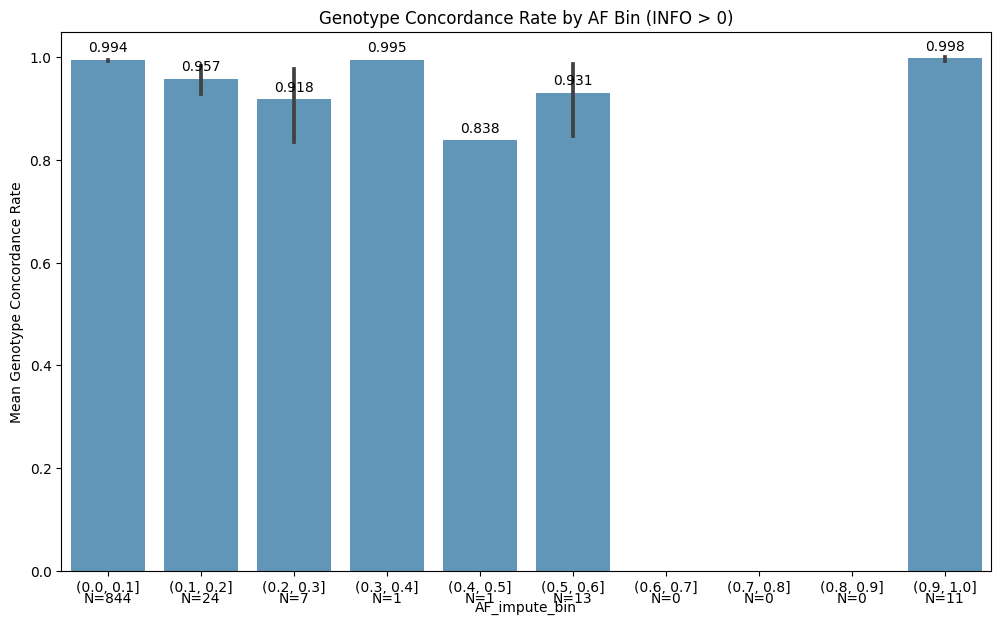

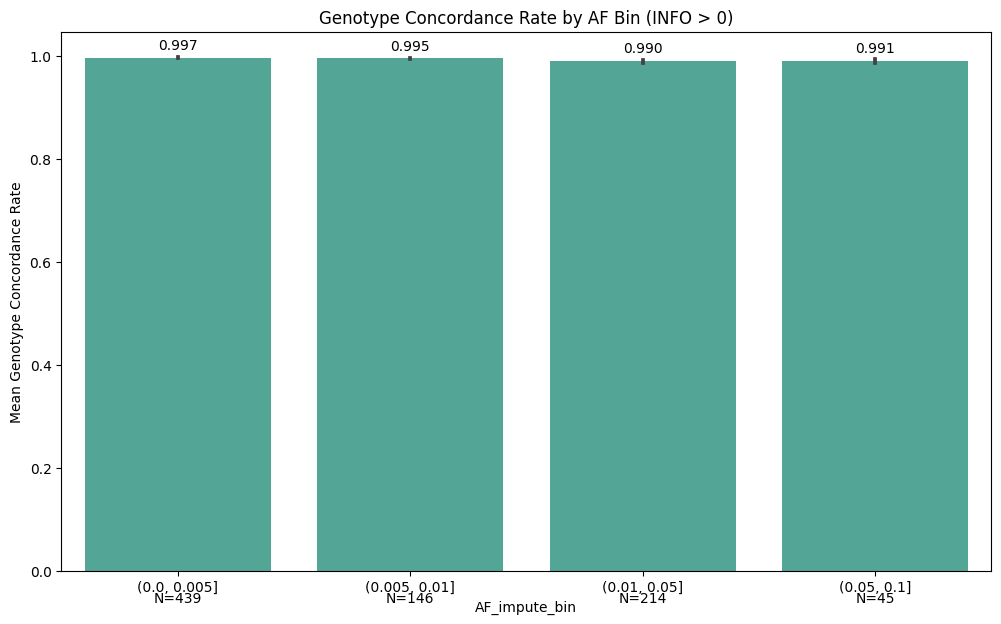

In [27]:
def plot_concordance_by_AF_bins(df, output_para=None, info_threshold=0, low_freq_bin=False):
    if low_freq_bin:  
        # Define AF bins
        bins = [0, 0.005, 0.01, 0.05, 0.1]
        output_para=f'{output_para}_low_freq'
        bin_color = '#45B39D'
    else:
        bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        bin_color = '#5499C7'
    df['AF_impute_bin'] = pd.cut(df['AF_impute'], bins)
    
    # Calculate count in each bin
    bin_counts = df.groupby('AF_impute_bin')['variant'].nunique()

    # Plot
    plt.figure(figsize=(12,7))
    barplot = sns.barplot(x='AF_impute_bin', y='concordance_rate', data=df, color=bin_color)
    plt.xlabel('AF_impute_bin')
    plt.ylabel('Mean Genotype Concordance Rate')
    plt.title(f'Genotype Concordance Rate by AF Bin (INFO > {info_threshold})')
    
    # Adding numerical labels on top of each bar
    for p, count in zip(barplot.patches, bin_counts):
        # Format the height to one decimal place and annotate the bar
        barplot.annotate(format(p.get_height(), '.3f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')
        
        # Annotate for count
        barplot.annotate(f'N={count}', 
                        (p.get_x() + p.get_width() / 2., 0), 
                        ha = 'center', va = 'center', 
                        xytext = (0, -20), 
                        textcoords = 'offset points')
    plt.savefig(f'{OUTPUT_DIR}{output_para}_concordance_by_AF_bins.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot concordance rates
plot_concordance_by_AF_bins(concordance_results, 'all')
plot_concordance_by_AF_bins(concordance_results, 'all', low_freq_bin=True)

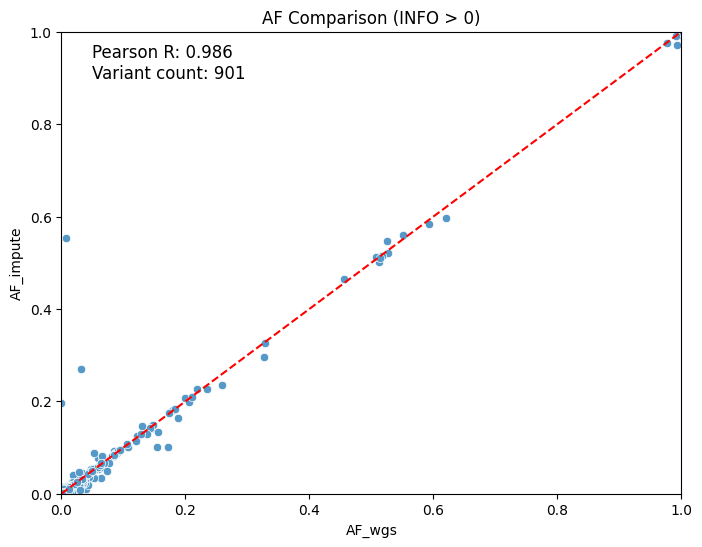

In [28]:
def plot_af(df, output_para=None, info_threshold=0):
    # Plot AF comparison between AF_impute and AF_wgs
    plt.figure(figsize=(8,6))
    scatterplot = sns.scatterplot(x='AF_wgs', y='AF_impute', data=df, color='#5499C7')
    plt.xlabel('AF_wgs')
    plt.ylabel('AF_impute')
    plt.title(f'AF Comparison (INFO > {info_threshold})')
    plt.xlim(0, 1)
    plt.ylim(0, 1)  
    
    # Drawing a diagonal line with slope 1
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # Calculate Pearson correlation coefficient
    r, _ = pearsonr(df['AF_wgs'], df['AF_impute'])
    plt.annotate(f'Pearson R: {r:.3f}\nVariant count: {len(df)}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

    plt.savefig(f'{OUTPUT_DIR}{output_para}_af_compare_wgs.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_af(concordance_results, 'all')

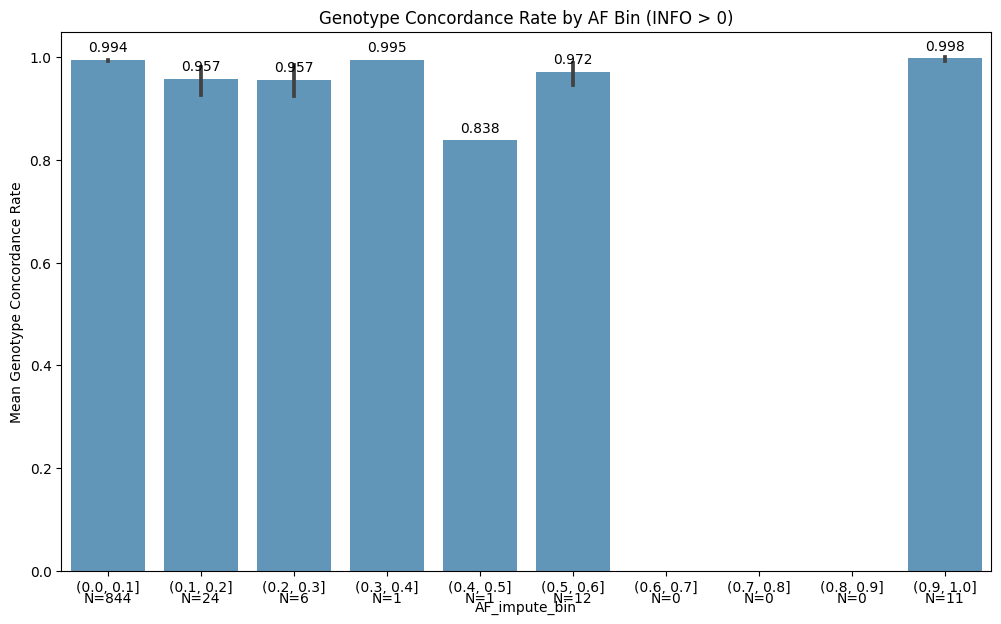

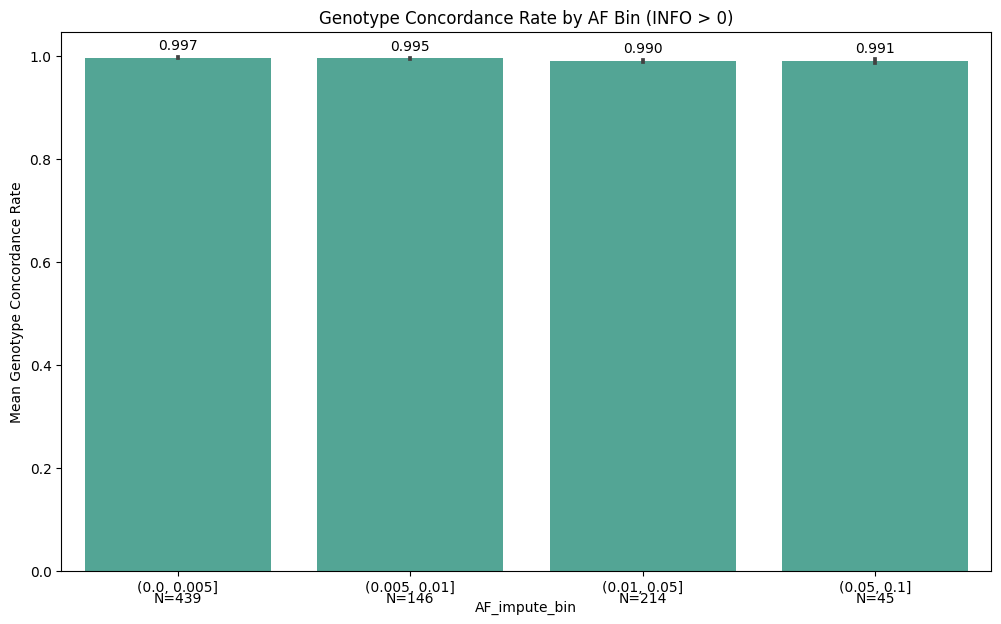

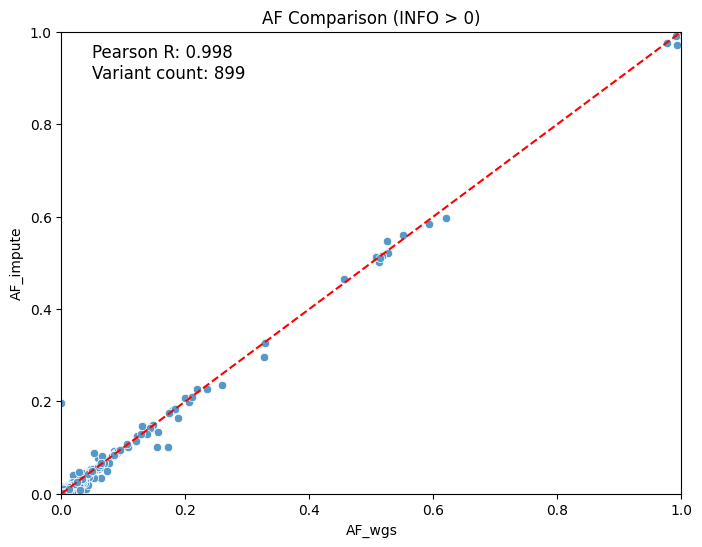

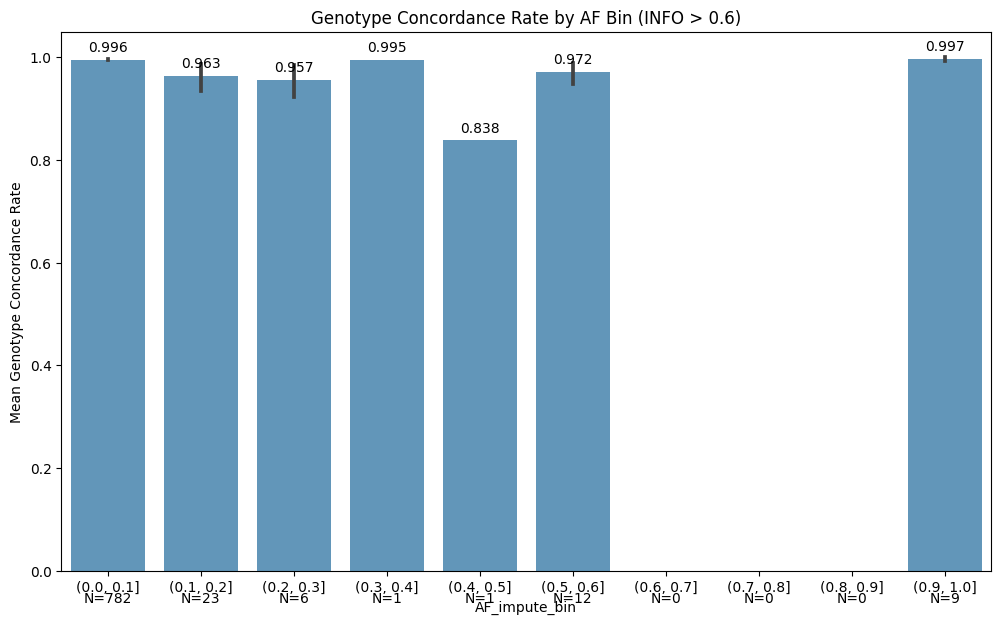

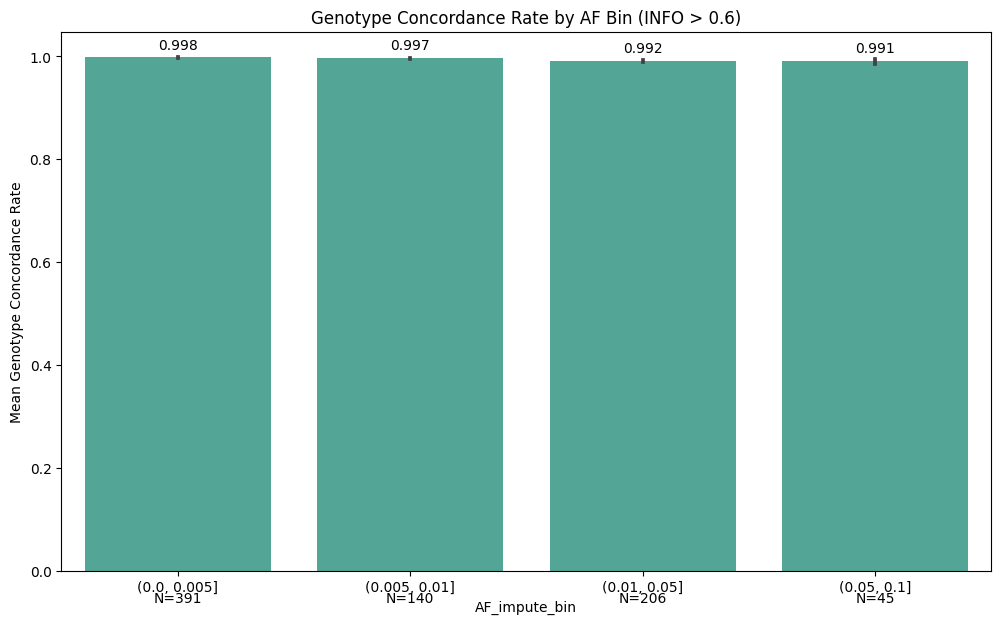

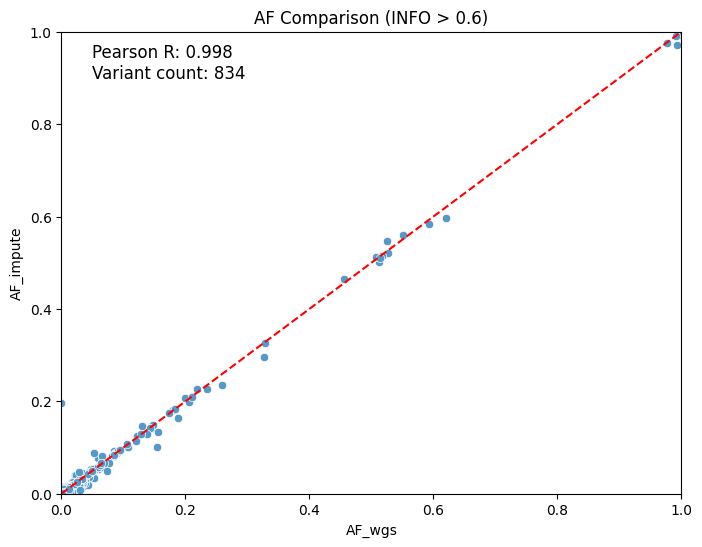

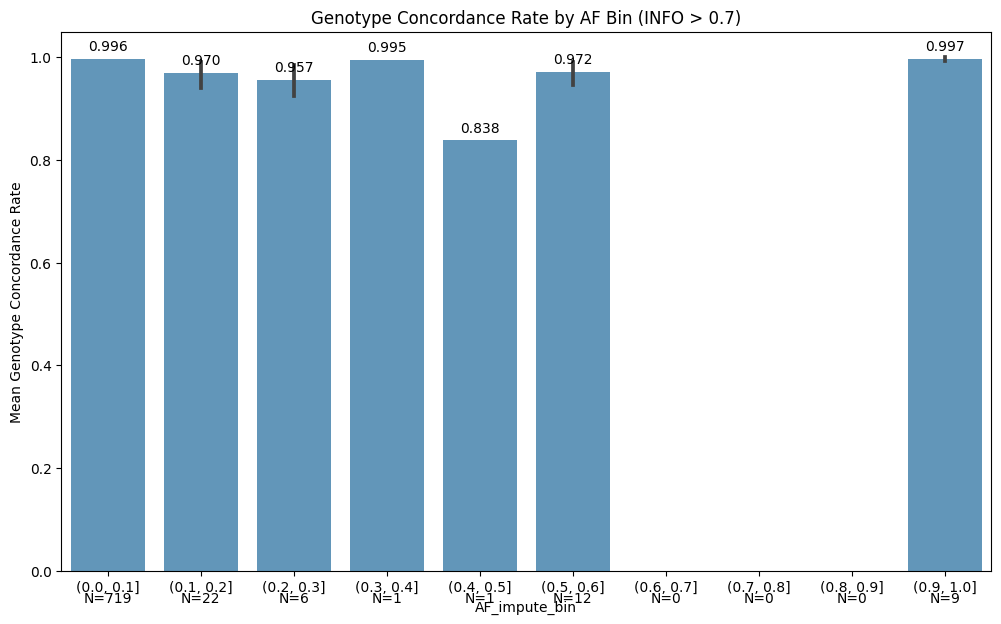

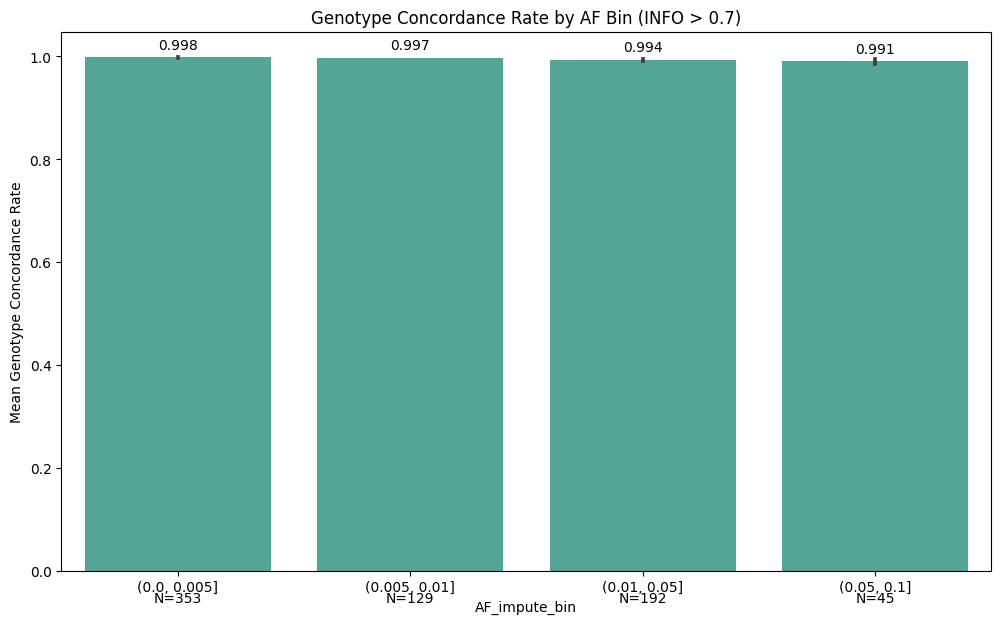

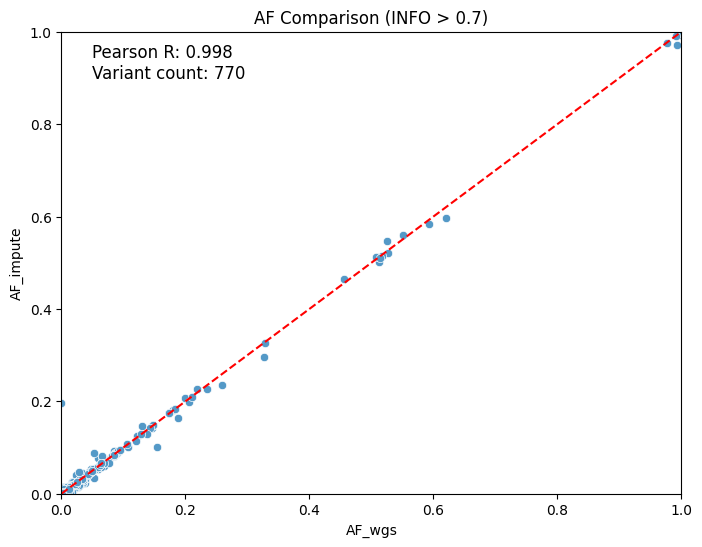

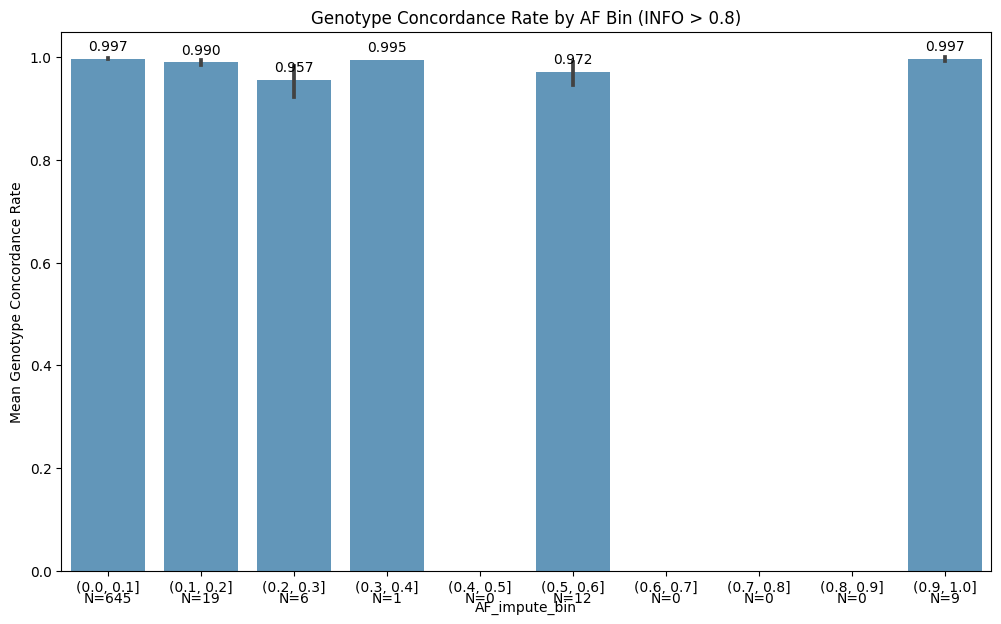

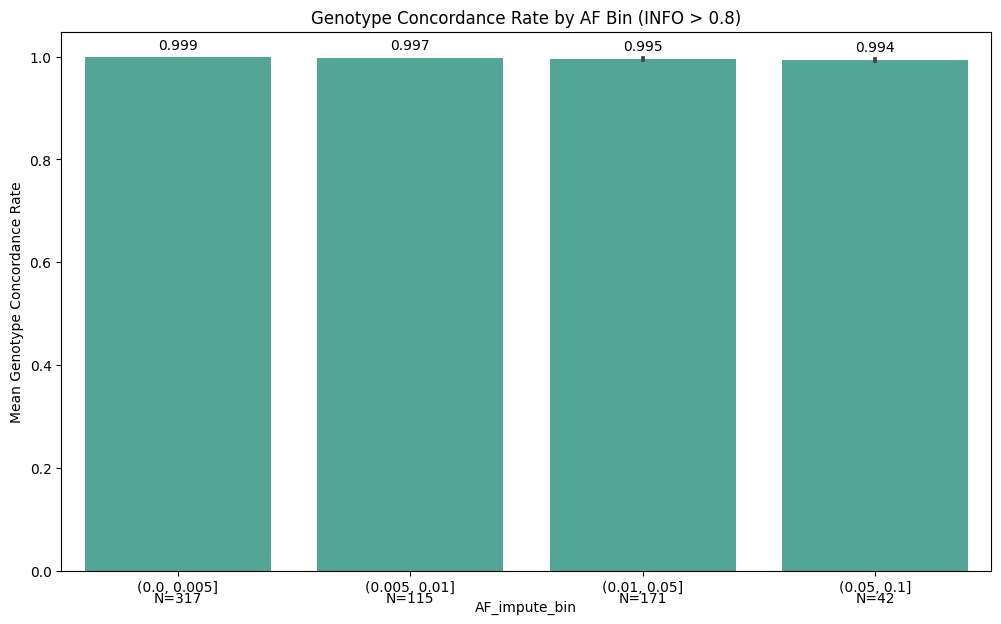

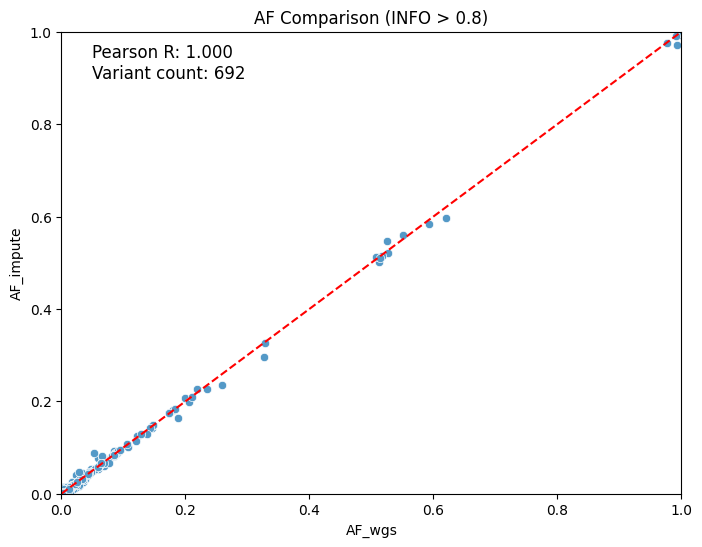

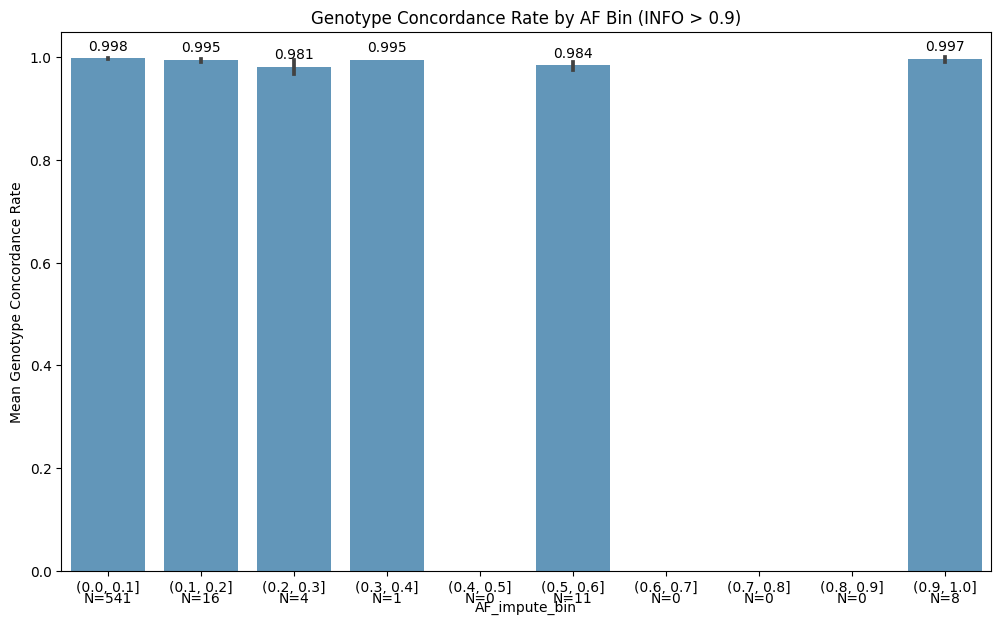

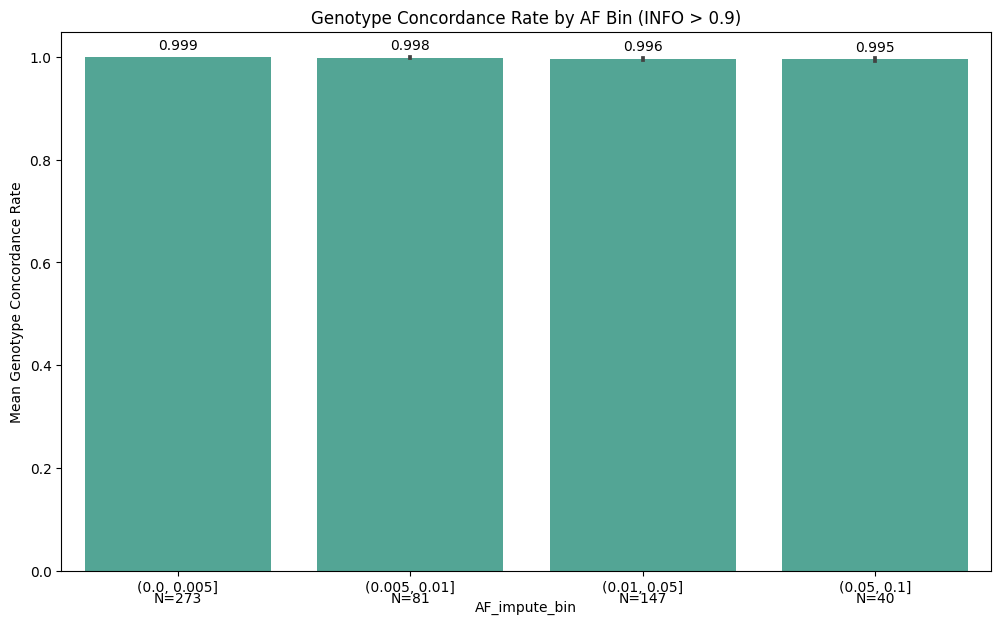

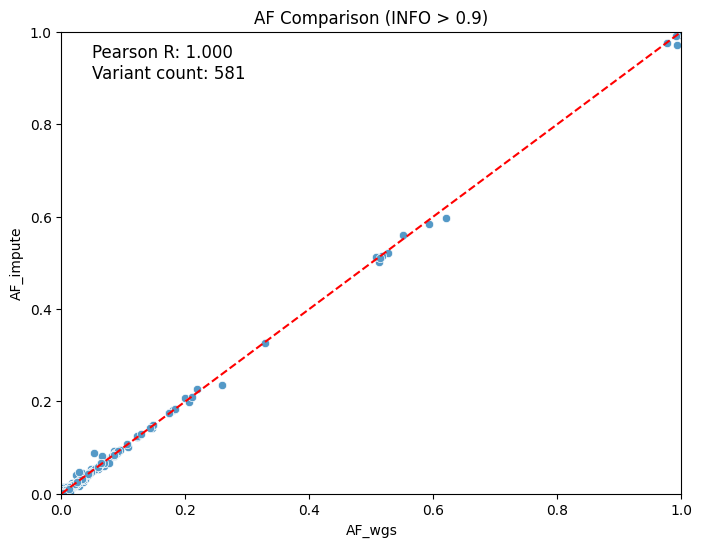

In [30]:
# Filter variants by INFO score and AF
concordance_results['AF_diff (abs)'] = abs(concordance_results['AF_impute'] - concordance_results['AF_wgs'])
concordance_results.to_csv(f'{OUTPUT_DIR}concordance_results.tsv', sep='\t', index=False)
filtered_results = concordance_results[concordance_results['AF_diff (abs)'] <= 0.2]

infos = [0, 0.6, 0.7, 0.8, 0.9]
for info in infos:
    filtered_results = filtered_results[filtered_results['INFO'] >= info]
    plot_concordance_by_AF_bins(filtered_results, f'info_{info}', info_threshold=info)
    plot_concordance_by_AF_bins(filtered_results, f'info_{info}', info_threshold=info, low_freq_bin=True)
    plot_af(filtered_results, f'info_{info}', info_threshold=info)

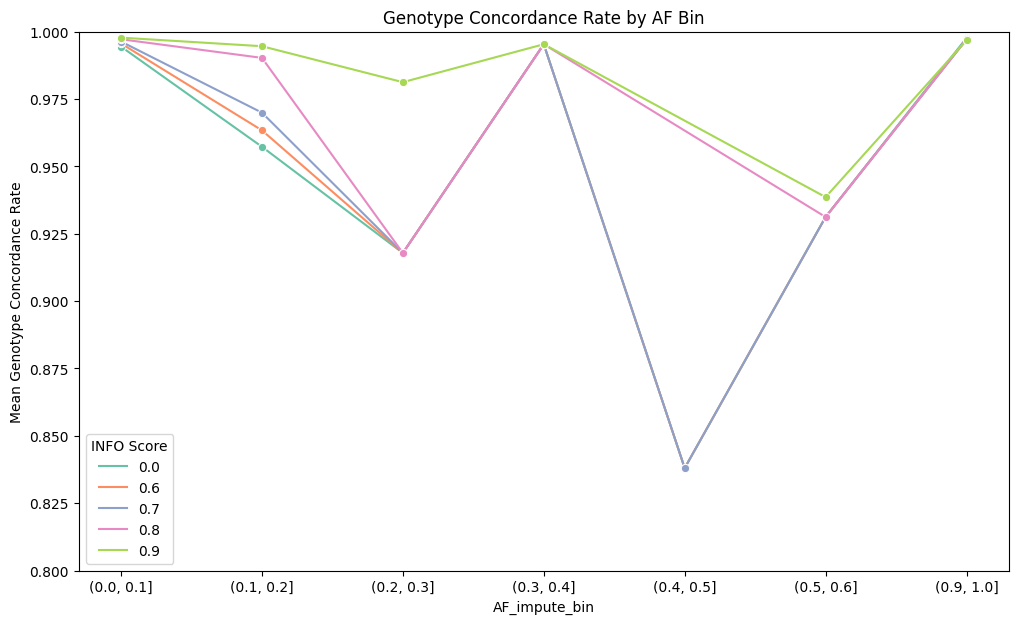

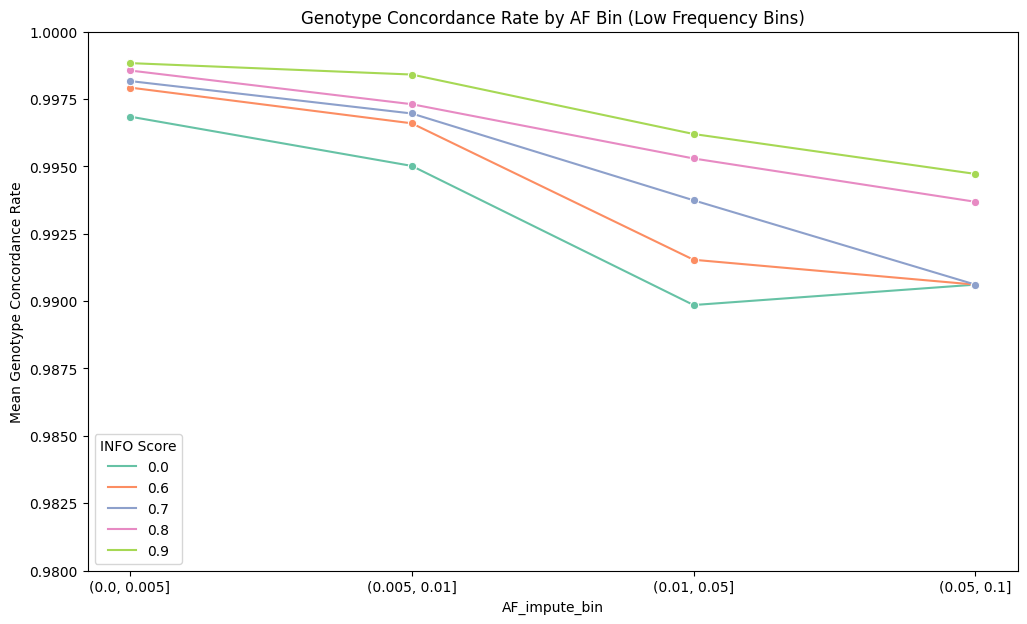

In [56]:
def prepare_data_for_plotting(df, info_scores):
    plot_data = []
    for info in info_scores:
        filtered_df = df[df['INFO'] >= info].copy()
        for low_freq in [False, True]:
            if low_freq:
                bins = [0, 0.005, 0.01, 0.05, 0.1]
            else:
                bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
            filtered_df['AF_impute_bin'] = pd.cut(filtered_df['AF_impute'], bins)
            concordance_by_bin = filtered_df.groupby('AF_impute_bin')['concordance_rate'].mean().reset_index()
            concordance_by_bin['INFO'] = info
            concordance_by_bin['Low_Freq'] = low_freq
            plot_data.append(concordance_by_bin)
    return pd.concat(plot_data).drop_duplicates()

def plot_concordance_lineplot(plot_data, low_freq=False, y_limits=None, color_palette="Set2"):
    df = plot_data[plot_data['Low_Freq'] == low_freq]

    # Drop rows with NA in relevant columns
    df = df.dropna(subset=['AF_impute_bin', 'concordance_rate', 'INFO'])

    # Reset index to ensure unique indices
    df = df.reset_index(drop=True)

    df['AF_impute_bin'] = df['AF_impute_bin'].astype(str)
    df['concordance_rate'] = pd.to_numeric(df['concordance_rate'], errors='coerce')
    if not pd.api.types.is_numeric_dtype(df['INFO']):
        df['INFO'] = df['INFO'].astype('category')

    # Now proceed with plotting
    plt.figure(figsize=(12,7))
    sns.lineplot(x='AF_impute_bin', y='concordance_rate', hue='INFO', data=df, palette=color_palette, marker='o')
    plt.xlabel('AF_impute_bin')
    plt.ylabel('Mean Genotype Concordance Rate')
    title_addition = " (Low Frequency Bins)" if low_freq else ""
    plt.title(f'Genotype Concordance Rate by AF Bin{title_addition}')
    plt.legend(title='INFO Score')
    
    if y_limits is not None:
        plt.ylim(y_limits)
    
    # Make directory for output
    output_dir = f'{OUTPUT_DIR}/concordance_lineplot/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    para = "low_freq＿" if low_freq else ""
    plt.savefig(f'{output_dir}{para}concordance_lineplot.png', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming concordance_results is your initial dataframe
infos = [0, 0.6, 0.7, 0.8, 0.9]
plot_data = prepare_data_for_plotting(concordance_results, infos)
plot_data

# Plot for normal and low frequency bins
plot_concordance_lineplot(plot_data, low_freq=False, y_limits=(0.8, 1))
plot_concordance_lineplot(plot_data, low_freq=True, y_limits=(0.98, 1))